3.环境 RNA 校正（可选）

- 3.1 准备环境
- 3.2 创建副本、移位对数归一化
- 3.3 邻域图、莱顿聚类
- 3.4 准备数据传递给 R
- 3.5 准备环境 RNA 校正所需的原始基因矩阵
- 3.6 调用 R 环境中的 SoupX
- 3.7 整合环境 RNA 校正结果
- 3.8 基础过滤

---

SoupX 背景矫正

- 可以在没有聚类信息的情况下运行出
- 如果提供基本聚类结果会更好
- SoupX 的结果对所使用的聚类类型并不强烈敏感。


In [1]:
## 3.1 准备环境

import scanpy as sc

import rpy2

# 设置参数
sc.settings.verbosity = 4
sc._settings.ScanpyConfig.n_jobs = -1
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

%load_ext rpy2.ipython 

In [4]:
## 3.2 读取数据、创建副本、移位对数归一化
adata = sc.read_h5ad("anndata_qc.h5ad")
adata_soup = adata.copy()  # backup
sc.pp.normalize_per_cell(adata_soup)
sc.pp.log1p(adata_soup)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [5]:
## 3.3 邻域图、莱顿聚类
"""
    -soupx可以不聚类,聚类后效果更好
"""
sc.pp.pca(adata_soup, random_state=123)  # add obsm
sc.pp.neighbors(adata_soup, random_state=123)  # add varm
sc.tl.leiden(adata_soup, key_added="soupx_groups", random_state=123)  # add obs

# Preprocess variables for SoupX
soupx_groups = adata_soup.obs["soupx_groups"]
del adata_soup

computing PCA
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 23 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:02)


In [6]:
## 3.4 准备数据传递给R
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [8]:
## 3.5 准备环境RNA校正所需的原始基因矩阵
## ：是原始矩阵在cellranger的输出中三合一
adata_raw = sc.read_h5ad("./anndata_raw.h5ad")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

batch = adata.obs["batch"]  # 多批次
batch_tod = adata_raw.obs["batch"]  # 多批次
del adata_raw

In [9]:
# %%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out
# ## 3.6 调用R环境中的SoupX
# library(SoupX)
# # specify row and column names of data
# rownames(data) = genes
# colnames(data) = cells
# # ensure correct sparse format for table of counts and table of droplets
# data <- as(data, "sparseMatrix")
# data_tod <- as(data_tod, "sparseMatrix")

# # Generate SoupChannel Object for SoupX
# sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# # Add extra meta data to the SoupChannel object
# soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
# sc = setSoupProfile(sc, soupProf)
# # Set cluster information in SoupChannel
# sc = setClusters(sc, soupx_groups)

# # Estimate contamination fraction
# sc  = autoEstCont(sc, doPlot=FALSE)
# # Infer corrected table of counts and rount to integer
# out = adjustCounts(sc, roundToInt = TRUE)

In [ ]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -i batch -i batch_tod -o out
library(SoupX)
library(Matrix)

# 初始化一个列表来存储每个批次的输出结果
out_list <- list()

# 确保数据是以稀疏矩阵的形式存储
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

rownames(data) = genes
colnames(data) = cells

# 获取唯一的批次名
unique_batches <- unique(c(batch, batch_tod))


# 为每个批次运行SoupX分析
for(b in unique_batches) {
  cat("Processing batch:", b, "\n")
  
  # 选取当前批次的数据
  batch_cells <- cells[batch == b]
  batch_data <- data[, batch_cells]
  
  batch_data_tod <- data_tod[, batch == b]
  
  batch_soupx_groups <- soupx_groups[batch == b]
  

  # 生成SoupChannel对象
  sc = SoupChannel(batch_data_tod, batch_data, calcSoupProfile = FALSE)
  
  # 添加额外的元数据
  soupProf = data.frame(row.names = genes, est = rowSums(batch_data)/sum(batch_data), counts = rowSums(batch_data))
  sc = setSoupProfile(sc, soupProf)
  
  # 设置群集信息
  sc = setClusters(sc, batch_soupx_groups)
  
  # 估计污染分数
  sc = autoEstCont(
    sc,
    doPlot=FALSE,
    soupQuantile=0.5,
    
    forceAccept=TRUE
  ) # TODO,报错时根据提示缩小
  
  # 计算校正后的计数表格并四舍五入为整数
  out = adjustCounts(sc, roundToInt = TRUE)
  
  # 将结果保存到列表中
  out_list[[as.character(b)]] <- list(data = out, batch = b)
}

## 准备合并
data_list = lapply(out_list, function(x) x$data)

# 检查所有数据的维度，确保他们可以被cbind合并
dims = lapply(data_list, dim)
print(dims)
# 如果所有数据的行数相同，可以使用do.call和cbind进行合并
if(length(unique(sapply(dims, `[`, 1))) == 1) {
  out = do.call(cbind, data_list)
} else {
  warning("Not all batches have the same number of rows, can't bind them together.")
}

In [ ]:
## 3.7 整合环境RNA校正结果
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]
# 查看均值
print(adata.layers["counts"].mean())
print(adata.layers["soupX_counts"].mean())

In [ ]:
## 3.8 soupx绘图
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 创建adata的一个副本用于绘图
adata_plot_soup = adata.copy()

# 计算校正前后的总计数和基因数
adata_plot_soup.obs["total_counts_before"] = (
    adata_plot_soup.layers["counts"].sum(axis=1).A1
)
adata_plot_soup.obs["n_genes_by_counts_before"] = (
    (adata_plot_soup.layers["counts"] > 0)
    .sum(axis=1)
    .A1  # .A1属性会将其转换为一个扁平的Numpy数组。
)

adata_plot_soup.obs["total_counts_after"] = (
    adata_plot_soup.layers["soupX_counts"].sum(axis=1).A1
)
adata_plot_soup.obs["n_genes_by_counts_after"] = (
    (adata_plot_soup.layers["soupX_counts"] > 0).sum(axis=1).A1
)

df = pd.DataFrame(
    {
        "total_counts_before": adata_plot_soup.obs["total_counts_before"],
        "n_genes_by_counts_before": adata_plot_soup.obs["n_genes_by_counts_before"],
        "total_counts_after": adata_plot_soup.obs["total_counts_after"],
        "n_genes_by_counts_after": adata_plot_soup.obs["n_genes_by_counts_after"],
    }
)

# 创建一个画布和两个子图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 校正前的联合分布
sns.scatterplot(
    x="total_counts_before",
    y="n_genes_by_counts_before",
    data=df,
    alpha=0.7,
    ax=axes[0],
)
sns.kdeplot(
    x="total_counts_before",
    y="n_genes_by_counts_before",
    data=df,
    color="r",
    levels=6,
    ax=axes[0],
)
axes[0].set_xlabel("Total Counts (Before)")
axes[0].set_ylabel("Num of Genes (Before)")
axes[0].set_title("Before Correction")

# 校正后的联合分布
sns.scatterplot(
    x="total_counts_after", y="n_genes_by_counts_after", data=df, alpha=0.7, ax=axes[1]
)
sns.kdeplot(
    x="total_counts_after",
    y="n_genes_by_counts_after",
    data=df,
    color="r",
    levels=6,
    ax=axes[1],
)
axes[1].set_xlabel("Total Counts (After)")
axes[1].set_ylabel("Num of Genes (After)")
axes[1].set_title("After Correction")

plt.tight_layout()
plt.savefig("figures/02-校正-环境RNA.pdf")
plt.show()

del adata_plot_soup

In [ ]:
## 3.9 基础过滤
"""
    - 由于soupX要求不能过滤gene只能过滤细胞,所以基础过滤放在这后面
    - soupX需要gene顺序和原始的一致
"""
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of genes after cell filter: {adata.n_vars}")

4.双峰检测

- 4.1 双连体过滤
- 4.2 保存


In [1]:
from IPython.display import Markdown as md  # jupyter md
import matplotlib as mpl

In [2]:
import scanpy as sc
import seaborn as sns

In [3]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

In [4]:
adata = sc.read("anndata_qc.h5ad")

In [8]:
# 4.1 双连体过滤
# obs 新增scrublet_score 和 predicted_doublet
sc.external.pp.scrublet(
    adata,
    batch_key="batch",  # 批次
    random_state=123,
)

Running Scrublet


/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


filtered out 2805 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    Gene indices [377] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    computing neighbors
    using data matrix X directly
    computed neighbors (0:00:13)
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 42.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%
filtered out 3055 genes that are detected in less than 3 cells
normalizing cou

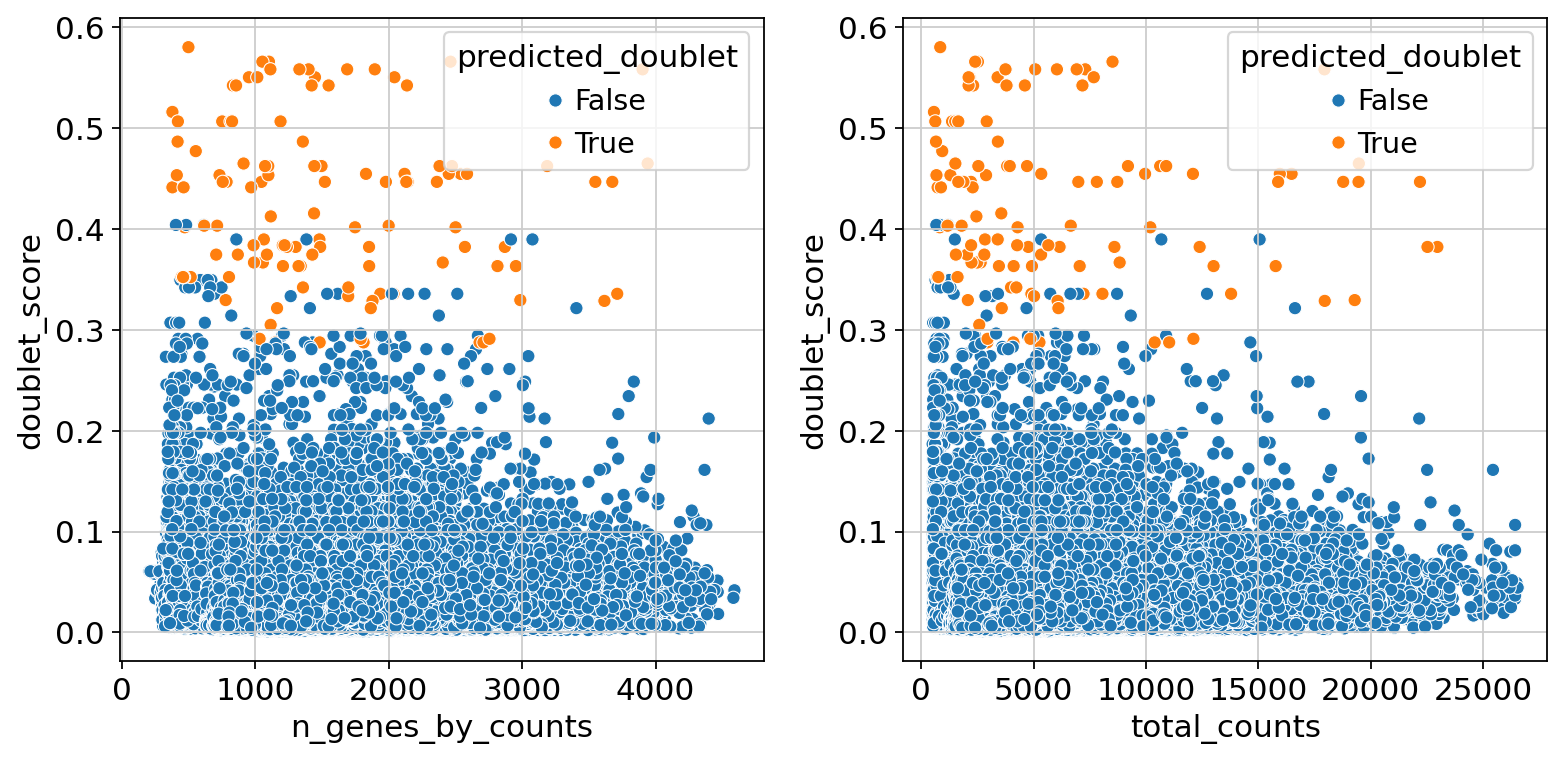

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(
    adata.obs,
    x="n_genes_by_counts",
    y="doublet_score",
    hue="predicted_doublet",
    ax=axes[0],
)
sns.scatterplot(
    adata.obs, x="total_counts", y="doublet_score", hue="predicted_doublet", ax=axes[1]
)
plt.tight_layout()
plt.savefig("figures/02-校正-双连体.pdf")
plt.savefig("figures/02-校正-双连体.tiff", dpi=600)
plt.show()

In [10]:
## 4.1.2 双连体过滤
# 新增uns.scrublet
# 打印过滤前的细胞总数
print(f"过滤前的细胞总数：{adata.shape[0]}")

# 打印预测为 doublet 的细胞数目
print(f"预测为 doublet 的细胞数目：{adata.obs['predicted_doublet'].sum()}")

# 过滤掉预测为 doublet 的细胞
adata = adata[adata.obs["predicted_doublet"] == False, :]

# 打印过滤后的细胞总数
print(f"过滤后的细胞总数：{adata.shape[0]}")

过滤前的细胞总数：100603
预测为 doublet 的细胞数目：119
过滤后的细胞总数：100484


In [11]:
# 4.2 保存
adata.write("anndata_scrublet.h5ad", compression="gzip")  # type: ignore

/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fanxi/projects/work/sc-rna/sc-project-4-irea/sc_rna/rep2/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fanxi/projects/wor

In [12]:
adata

AnnData object with n_obs × n_vars = 100484 × 17269
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', '